In [123]:
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import sklearn
import math
import seaborn as sns
from matplotlib import rcParams
from datetime import date
from pandas.tseries.holiday import AbstractHolidayCalendar
import statsmodels.api as sm
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
from tools import functions
import os
from sklearn.ensemble import RandomForestRegressor

%matplotlib inline 


In [124]:
df=pd.read_csv('frame.csv',usecols=['Date', 'load', 'hour', 'year', 'month', 'day', 'weekday',
       'daytime', 'holiday', 'non_working', 'season', 'temp'],parse_dates=['Date'],index_col=['Date'])

In [125]:
df.drop(['day','weekday','holiday','season'],axis=1,inplace=True)

In [126]:
cat_cols = ['hour','daytime']

In [127]:
for col in cat_cols:
    df[col] = df[col].astype('category')

In [128]:
df_dum = pd.get_dummies(df)

In [129]:
def error_metrics(y_pred, y_truth, model_name=None):
    dict_error = dict()

    if isinstance(y_pred, np.ndarray):
        y_pred = y_pred
    else:
        y_pred = y_pred.to_numpy()

    if isinstance(y_truth, np.ndarray):
        y_truth = y_truth
    else:
        y_truth = y_truth.to_numpy()


    RMSE = np.sqrt(mean_squared_error(y_truth, y_pred))


    R2 = r2_score(y_truth, y_pred)


    MAE = mean_absolute_error(y_truth, y_pred)


    MAPE = (np.mean(np.abs((y_truth - y_pred) / y_truth)) * 100)


    name = ['RMSE', 'R2', 'MAE', 'MAPE']
    value = [RMSE, R2, MAE, MAPE]

    a=pd.DataFrame(value,index=name,columns=[model_name])
    
    
    return a 

In [130]:
cols_to_transform = ['temp'] 
X_train, X_test, y_train, y_test = functions.train_test(df_dum, test_size = 0.15, scale = True, cols_to_transform=cols_to_transform)


lm = LinearRegression()
lm.fit(X_train, y_train)

LinearRegression()

Text(0.5, 0, 'Features')

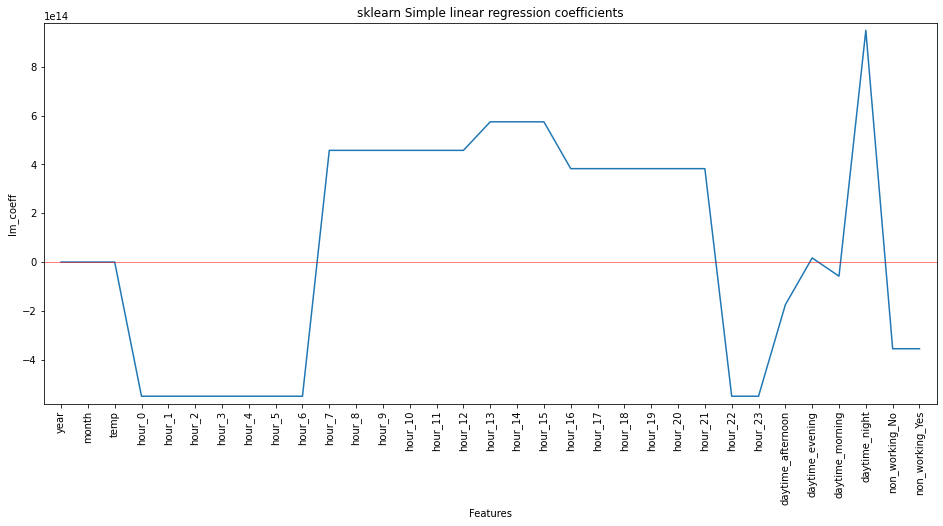

In [131]:
plt.figure(figsize = (16, 7))
plt.plot(range(len(X_train.columns)), lm.coef_)
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
plt.margins(0.02)
plt.axhline(0, linewidth = 0.5, color = 'r')
plt.title('sklearn Simple linear regression coefficients')
plt.ylabel('lm_coeff')
plt.xlabel('Features')

In [132]:
error_metrics(lm.predict(X_test), y_test, model_name = 'linear regression')

,linear regression
RMSE,5954.654238
R2,0.297772
MAE,4930.123110
MAPE,10.008627


In [133]:
linear=error_metrics(lm.predict(X_test), y_test, model_name = 'Linear regression')

Text(0.5, 0, 'Features')

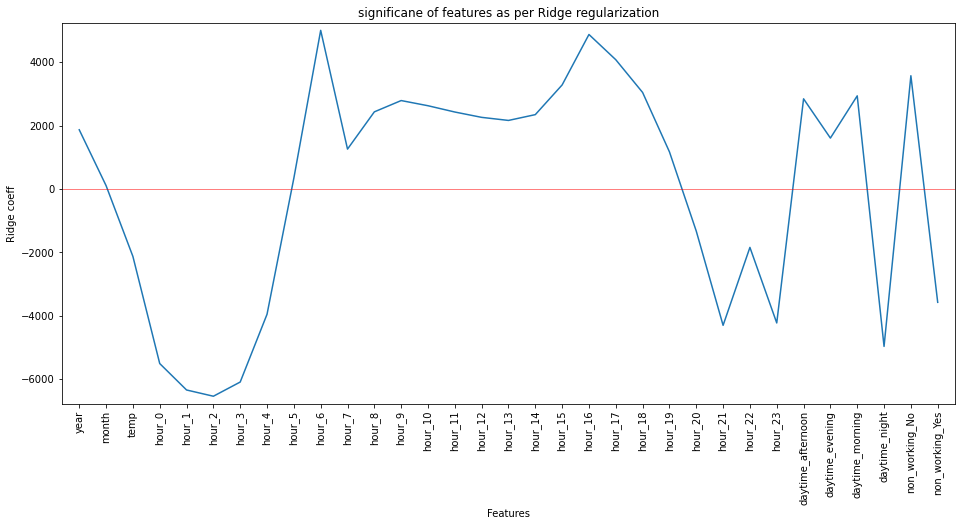

In [134]:
from sklearn.linear_model import Ridge


ridge = Ridge(alpha = 0.2, normalize = True) 

ridge.fit(X_train, y_train)


ridge_coef = ridge.coef_

plt.figure(figsize = (16, 7))
plt.plot(range(len(X_train.columns)), ridge_coef)
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
plt.margins(0.02)
plt.axhline(0, linewidth = 0.5, color = 'r')
plt.title('significane of features as per Ridge regularization')
plt.ylabel('Ridge coeff')
plt.xlabel('Features')

In [135]:
ridge=error_metrics(ridge.predict(X_test), y_test, model_name = 'Ridge regression')

In [136]:
a=ridge

Text(0.5, 0, 'Features')

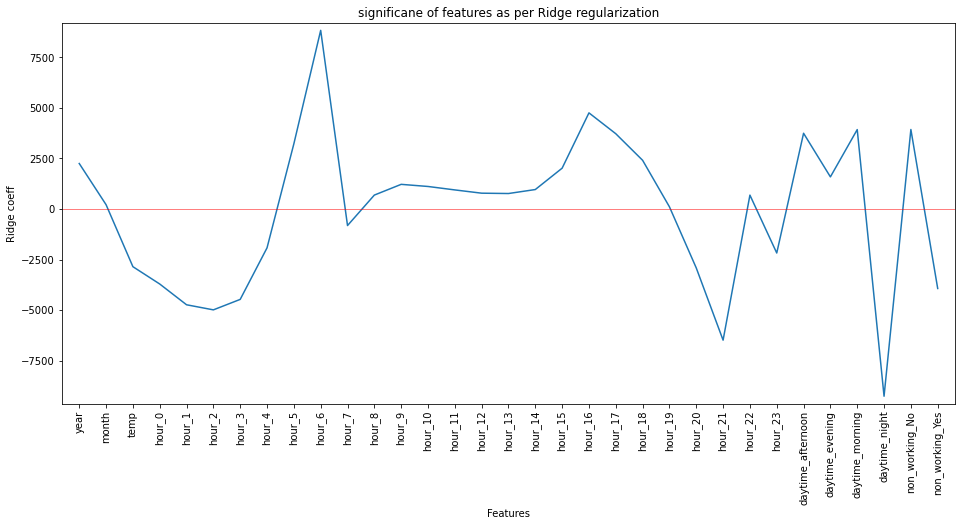

In [137]:
from sklearn.linear_model import BayesianRidge


Bayes = BayesianRidge() 

Bayes.fit(X_train, y_train)


ridge_coef = Bayes.coef_

plt.figure(figsize = (16, 7))
plt.plot(range(len(X_train.columns)), ridge_coef)
plt.xticks(range(len(X_train.columns)), X_train.columns.values, rotation = 90)
plt.margins(0.02)
plt.axhline(0, linewidth = 0.5, color = 'r')
plt.title('significane of features as per Ridge regularization')
plt.ylabel('Ridge coeff')
plt.xlabel('Features')

In [138]:
functions.plot_ts_pred(y_test, Bayes.predict(X_test), model_name='Ridge regression', og_ts_opacity = 0.5, pred_ts_opacity = 0.5)

In [88]:
bayes=error_metrics(Bayes.predict(X_test), y_test, model_name = 'Bayesian Ridge')

In [139]:
n_estimators = [int(x) for x in np.linspace(10, 200, 10, endpoint=True)]
max_features = ['auto', 'sqrt']
max_depth = list(range(1,6))
# Create the random grid
random_grid = {'n_estimators': n_estimators, 'max_features': max_features, 'max_depth':max_depth}
print(random_grid)

{'n_estimators': [10, 31, 52, 73, 94, 115, 136, 157, 178, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [1, 2, 3, 4, 5]}


In [140]:
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestRegressor()

# Creating a time series split as discussed in the Introduction
tscv = TimeSeriesSplit(n_splits=5)
# Random search of parameters
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               cv = tscv, verbose=2, random_state = 42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)

rf_random.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:   22.3s
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:   24.1s finished


{'n_estimators': 73, 'max_features': 'auto', 'max_depth': 5}

In [141]:
random=error_metrics(rf_random.predict(X_test), y_test, model_name = 'Tuned Random forest with reduced hour space')

In [142]:
for i in range(24):
    df_dum['lag'+str(i+1)] = df_dum['temp'].shift(i+1)
lag_sdge = df_dum.dropna()
cols_to_transform = ['temp']
# Adding the energy consumption lags to the columns to transform 
list_lags = ['lag'+str(i+1) for i in range(24)]
cols_to_transform.extend(list_lags)

X_train_lag, X_test_lag, y_train_lag, y_test_lag = functions.train_test(lag_sdge, \
                                                              test_size = 0.15, scale = True, \
                                                              cols_to_transform=cols_to_transform)

In [143]:
from sklearn.linear_model import ElasticNet
elastic_net_lag = ElasticNet(l1_ratio = 1, alpha=0.2)
elastic_net_lag.fit(X_train_lag, y_train_lag)

ElasticNet(alpha=0.2, l1_ratio=1)

Text(0.5, 0, 'Features')

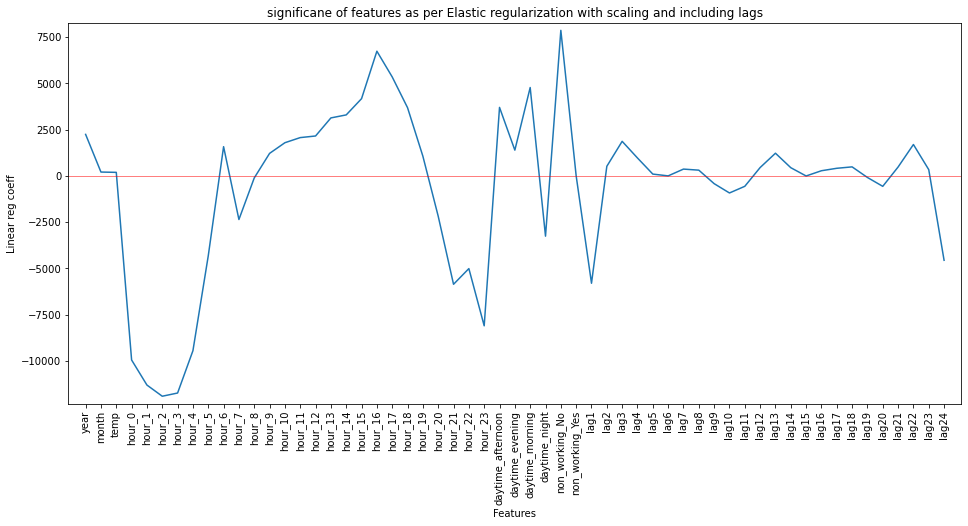

In [144]:
plt.figure(figsize = (16, 7))
plt.plot(range(len(X_train_lag.columns)), elastic_net_lag.coef_)
plt.xticks(range(len(X_train_lag.columns)), X_train_lag.columns.values, rotation = 90)
plt.margins(0.02)
plt.axhline(0, linewidth = 0.5, color = 'r')
plt.title('significane of features as per Elastic regularization with scaling and including lags')
plt.ylabel('Linear reg coeff')
plt.xlabel('Features')

In [145]:
rf = RandomForestRegressor()
tscv = TimeSeriesSplit(n_splits=5)
rflag = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, 
                               cv = tscv, verbose=2, random_state = 42, n_jobs = -1)
rflag.fit(X_train_lag, y_train_lag)
rflag.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  33 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  50 out of  50 | elapsed:  1.9min finished


{'n_estimators': 73, 'max_features': 'auto', 'max_depth': 5}

In [146]:
laged_random=error_metrics(rflag.predict(X_test_lag), y_test_lag, model_name = 'Random forest with all lags')
laged_elastic=error_metrics(elastic_net_lag.predict(X_test_lag), y_test_lag, model_name = 'Elastic net with all lags')

In [147]:
#a['Ridge regression']=ridge
a['Linear Regression']=linear
a['Hypertuned random forest']=random
a['Laged Elastic Net']=laged_elastic
a['Laged random forest']=laged_random

In [148]:
import dataframe_image as dfi
dfi.export(a, 'models1.png')

In [113]:
superr=pd.read_csv('super_model.csv',index_col=['Unnamed: 0'])
ef=pd.read_csv('ef_fu.csv',index_col=['Unnamed: 0'])
sarima=pd.read_csv('aroma_resul.csv',index_col=['Unnamed: 0'])
fb=pd.read_csv('fb_result.csv',index_col=['Unnamed: 0'])


In [114]:
ef['SARIMAX']=sarima
ef['Facebook prophet']=fb
ef['Long-term forecasting with Vanilla LSTM']=lg
ef['Long-term forecasting with stacked LSTM']=lgs
ef['Laged Fourier Super Model']=superr

In [115]:
dfi.export(ef, 'models2.png')

In [100]:
seed_value= 0
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler
from numpy import array
def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

size = int(len(df['load']) - 50)
n_steps=5
n_features = 1

In [116]:
import warnings
warnings.filterwarnings("ignore")

X=df['load'].values
scaler = MinMaxScaler(feature_range = (0, 1))
X=scaler.fit_transform(X.reshape(-1, 1))
X_train,y_train=split_sequence(X[0:size], n_steps)
X_test,y_test=split_sequence(X[size:len(df)], n_steps)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=100, verbose=1)
X_test = X_test.reshape((len(X_test), n_steps, n_features))
predictions = model.predict(X_test, verbose=0)
y_test=scaler.inverse_transform(y_test)
predictions = scaler.inverse_transform(predictions)
error_metrics(predictions, y_test, model_name='Long-term forecasting with Vanilla LSTM ')


Epoch 1/100
1368/1368 [==============================] - 7s 5ms/step - loss: 0.0071
Epoch 2/100
1368/1368 [==============================] - 8s 6ms/step - loss: 0.0010
Epoch 3/100
1368/1368 [==============================] - 8s 5ms/step - loss: 7.6435e-04
Epoch 4/100
1368/1368 [==============================] - 7s 5ms/step - loss: 6.5571e-04
Epoch 5/100
1368/1368 [==============================] - 8s 6ms/step - loss: 6.0286e-04
Epoch 6/100
1368/1368 [==============================] - 8s 6ms/step - loss: 5.9474e-04
Epoch 7/100
1368/1368 [==============================] - 8s 6ms/step - loss: 5.7479e-04
Epoch 8/100
1368/1368 [==============================] - 8s 6ms/step - loss: 5.6739e-04
Epoch 9/100
1368/1368 [==============================] - 7s 5ms/step - loss: 5.4526e-04
Epoch 10/100
1368/1368 [==============================] - 8s 6ms/step - loss: 5.3005e-04
Epoch 11/100
1368/1368 [==============================] - 8s 6ms/step - loss: 5.2613e-04
Epoch 12/100
1368/1368 [==============

KeyboardInterrupt: 

In [260]:
error_metrics(predictions, y_test, model_name='Long-term forecasting with Vanilla LSTM ').to_csv('Long-term forecasting with Vanilla LSTM.csv')

In [261]:

X=df['load'].values
scaler = MinMaxScaler(feature_range = (0, 1))
X=scaler.fit_transform(X.reshape(-1, 1))
X_train,y_train=split_sequence(X[0:size], n_steps)
X_test,y_test=split_sequence(X[size:len(df)], n_steps)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=400, verbose=0)
    
X_test = X_test.reshape((len(X_test), n_steps, n_features))
predictions = model.predict(X_test, verbose=0)
y_test=scaler.inverse_transform(y_test)
predictions = scaler.inverse_transform(predictions)
error_metrics(predictions, y_test, model_name='Long-term forecasting with Vanilla LSTM ')

,Long-term forecasting with Vanilla LSTM
RMSE,1092.895220
R2,0.966097
MAE,778.856163
MAPE,1.398230


In [262]:
error_metrics(predictions, y_test, model_name='Long-term forecasting with stacked LSTM ').to_csv('stacked LSTM.csv')

In [110]:
from numpy import array
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
 
# split a univariate sequence into samples
X=df['load'].values
scaler = MinMaxScaler(feature_range = (0, 1))
X=scaler.fit_transform(X.reshape(-1, 1))
X_train,y_train=split_sequence(X[0:size], n_steps)
X_test,y_test=split_sequence(X[size:len(df)], n_steps)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
 

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(n_steps, n_features)))
model.add(MaxPooling1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X_train, y_train, epochs=100, verbose=1)

X_test = X_test.reshape((len(X_test), n_steps, n_features))
predictions = model.predict(X_test, verbose=0)
y_test=scaler.inverse_transform(y_test)
predictions = scaler.inverse_transform(predictions)


Epoch 1/100
1368/1368 [==============================] - 2s 2ms/step - loss: 0.0028
Epoch 2/100
1368/1368 [==============================] - 2s 1ms/step - loss: 8.9589e-04
Epoch 3/100
1368/1368 [==============================] - 2s 2ms/step - loss: 7.8749e-04
Epoch 4/100
1368/1368 [==============================] - 2s 1ms/step - loss: 7.1414e-04
Epoch 5/100
1368/1368 [==============================] - 2s 2ms/step - loss: 6.6844e-04
Epoch 6/100
1368/1368 [==============================] - 2s 1ms/step - loss: 6.6618e-04
Epoch 7/100
1368/1368 [==============================] - 2s 1ms/step - loss: 6.2961e-04
Epoch 8/100
1368/1368 [==============================] - 2s 1ms/step - loss: 6.1798e-04
Epoch 9/100
1368/1368 [==============================] - 2s 1ms/step - loss: 6.1035e-04
Epoch 10/100
1368/1368 [==============================] - 2s 1ms/step - loss: 5.9961e-04
Epoch 11/100
1368/1368 [==============================] - 2s 1ms/step - loss: 5.9171e-04
Epoch 12/100
1368/1368 [==========

1368/1368 [==============================] - 2s 1ms/step - loss: 4.3838e-04
Epoch 94/100
1368/1368 [==============================] - 2s 1ms/step - loss: 4.3973e-04
Epoch 95/100
1368/1368 [==============================] - 2s 1ms/step - loss: 4.3686e-04
Epoch 96/100
1368/1368 [==============================] - 2s 1ms/step - loss: 4.3471e-04
Epoch 97/100
1368/1368 [==============================] - 2s 1ms/step - loss: 4.3883e-04
Epoch 98/100
1368/1368 [==============================] - 2s 1ms/step - loss: 4.3520e-04
Epoch 99/100
1368/1368 [==============================] - 2s 1ms/step - loss: 4.3811e-04
Epoch 100/100
1368/1368 [==============================] - 2s 1ms/step - loss: 4.3386e-04


,Long-term forecasting with Convolutional LSTM
RMSE,1268.750209
R2,0.954308
MAE,871.784549
MAPE,1.573727


In [111]:
error_metrics(predictions, y_test, model_name='Long-term forecasting with Convolutional LSTM ').to_csv('Convolutional LSTM.csv')

In [121]:
lg=pd.read_csv('Long-term forecasting with Vanilla LSTM.csv',index_col=['Unnamed: 0'])
lgs=pd.read_csv('stacked LSTM.csv',index_col=['Unnamed: 0'])
lgc=pd.read_csv('Convolutional LSTM.csv',index_col=['Unnamed: 0'])


In [122]:
lg['Stacked LSTM']=lgs
lg['Convolutional LSTM']=lgc
dfi.export(lg, 'models3.png')